# DA5401 A5 — Manifold Visualization 

### Part A: Data Loading and Preprocessing
Data Loading

We first load the Yeast dataset ARFF file and separate its features and labels. The Yeast data is a multi-label dataset with 103 gene-expression features and 14 binary target labels. We use SciPy’s ARFF loader and pandas to read the file into a DataFrame, then split it into a feature matrix X and a label matrix Y. In the ARFF, the first 103 attributes (Att1–Att103) are numeric features and the last 14 attributes (Class1–Class14) are the binary labels. We convert the label columns to integer type (0/1) for convenience.

In [2]:
import numpy as np
import pandas as pd
from scipy.io import arff

# Load ARFF file
data, meta = arff.loadarff("yeast.arff")
df = pd.DataFrame(data)

# Separate features (103) and labels (14)
X = df.iloc[:, :-14]
Y = df.iloc[:, -14:].astype(int)  # convert labels from bytes to int
print("Shape of X (features):", X.shape)
print("Shape of Y (labels):", Y.shape)


Shape of X (features): (2417, 103)
Shape of Y (labels): (2417, 14)


We check the dimensions of the loaded matrices. The Yeast dataset contains 2417 instances and 103 features, and each instance has 14 binary labels. After loading, X.shape should be (2417, 103) and Y.shape should be (2417, 14). The code above prints these shapes to confirm the data was loaded correctly.

The dataset has:
- **N = number of samples** (rows in X, Y).
- **103 features** (columns in X).
- **14 labels** (columns in Y).

This dimensionality check is important before applying dimensionality reduction, so we ensure we’re feeding the correct number of features and labels.


In [3]:
# Report number of samples and features
n_samples, n_features = X.shape
print(f"Number of samples: {n_samples}")
print(f"Number of features: {n_features}")
print(f"Number of labels: {Y.shape[1]}")


Number of samples: 2417
Number of features: 103
Number of labels: 14


### Label Simplification for Visualization
Since visualizing all 14 labels would be cluttered, we collapse them into 4 categories:

1. The **two most frequent single-label classes** (individual labels with the most samples).  
2. The **most frequent multi-label combination** (samples with >1 labels).  
3. An **Other** category for everything else.

We will map these to integers:
- 0 → Top Single Label 1
- 1 → Top Single Label 2
- 2 → Top Multi-Label Combo
- 3 → Other


In [4]:
from collections import Counter

# Step 1: find top 2 single-label classes
single_mask = (Y.sum(axis=1) == 1)
single_counts = Y[single_mask].sum().sort_values(ascending=False)
top2_idx = [Y.columns.get_loc(c) for c in single_counts.index[:2]]
print("Top 2 single-label classes:", list(single_counts.index[:2]))

# Step 2: find most common multi-label combination
combos = [tuple(row) for row in Y.values]
combo_counts = Counter(combos)
most_common_multi = None
for combo, cnt in combo_counts.most_common():
    if sum(combo) > 1:   # must be multi-label
        most_common_multi = combo
        break
print("Most common multi-label combination:", most_common_multi)

# Step 3: build new categorical target (numeric 0–3)
new_target = np.full(Y.shape[0], 3)  # default "Other"
for i, row in enumerate(Y.values):
    if row[top2_idx[0]] == 1 and row.sum() == 1:
        new_target[i] = 0
    elif row[top2_idx[1]] == 1 and row.sum() == 1:
        new_target[i] = 1
    elif tuple(row) == most_common_multi:
        new_target[i] = 2

# Step 4: check distribution
unique, counts = np.unique(new_target, return_counts=True)
print("\nDistribution of new categorical target for visualization:")
for u, c in zip(unique, counts):
    label = {0: "TopLabel1", 1: "TopLabel2", 2: "TopMultiCombo", 3: "Other"}[u]
    print(f"{label} ({u}): {c}")


Top 2 single-label classes: ['Class1', 'Class2']
Most common multi-label combination: (np.int64(0), np.int64(0), np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(1), np.int64(0))

Distribution of new categorical target for visualization:
TopLabel1 (0): 32
TopMultiCombo (2): 237
Other (3): 2148


### Why is scaling important?
Distance-based methods (like K-Nearest Neighbors, t-SNE, Isomap) compute distances between examples. If different features are on different scales, those with larger ranges will dominate the distance metric
- Feature standardization (zero mean, unit variance) ensures that all features contribute equally. Indeed, as noted in the literature, “distance-based algorithms such as K-Nearest Neighbors (KNN) or SVM calculate distances… and if the features have different scales, the distances may be dominated by the features with larger scales”
- We therefore apply StandardScaler to the feature matrix X.


In [5]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print("Scaled feature matrix shape:", X_scaled.shape)


Scaled feature matrix shape: (2417, 103)


### Visualizing Scaling Effect

Below we compare the distribution of a few features **before** and **after scaling**.  
This shows how features originally had different ranges, but after scaling they are centered at 0 with variance 1.


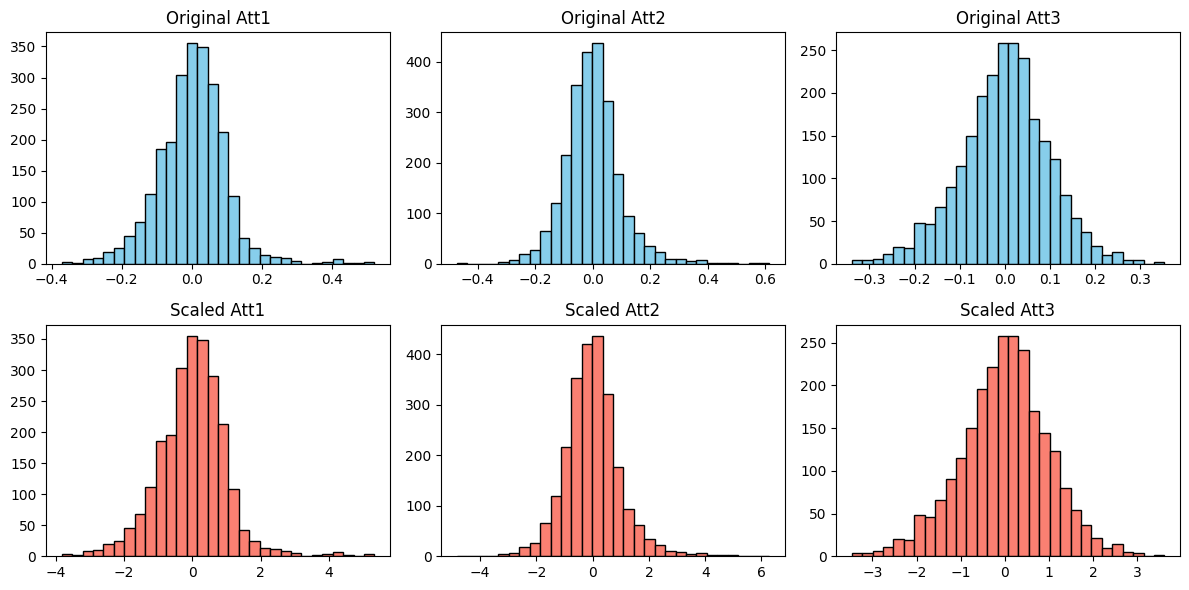

In [6]:
import matplotlib.pyplot as plt

# Pick first 3 features as example
feature_indices = [0, 1, 2]
feature_names = X.columns[feature_indices]

plt.figure(figsize=(12,6))

for i, idx in enumerate(feature_indices):
    plt.subplot(2, 3, i+1)
    plt.hist(X.iloc[:, idx], bins=30, color='skyblue', edgecolor='k')
    plt.title(f"Original {feature_names[i]}")
    
    plt.subplot(2, 3, i+4)
    plt.hist(X_scaled[:, idx], bins=30, color='salmon', edgecolor='k')
    plt.title(f"Scaled {feature_names[i]}")

plt.tight_layout()
plt.show()


# Part B: t-SNE and Veracity Inspection

In this part, we apply **t-SNE** to the scaled feature matrix `X_scaled` to reduce it to 2D.  
We experiment with different perplexity values (5, 30, 50), visualize the embeddings, and analyze 
regions of **noisy/ambiguous labels**, **outliers**, and **hard-to-learn samples**.


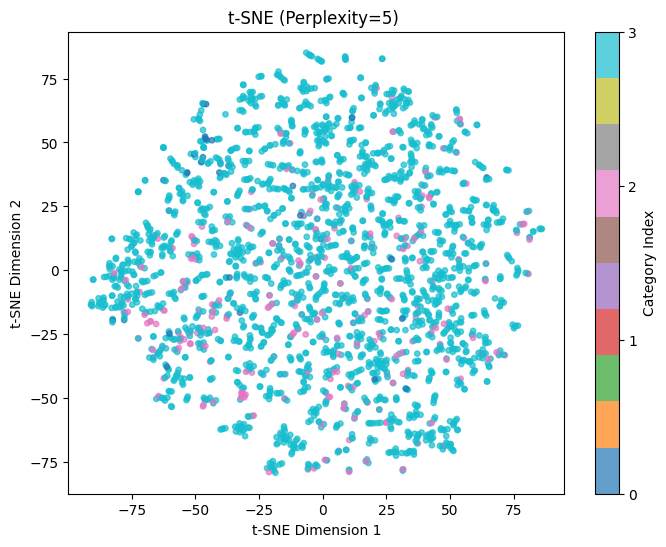

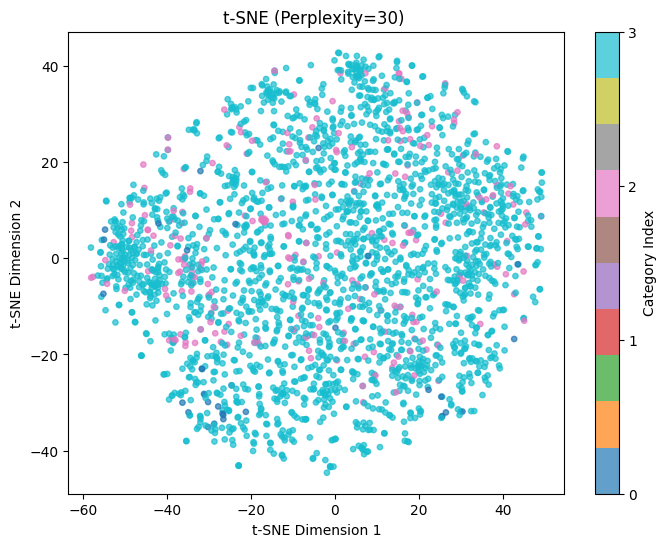

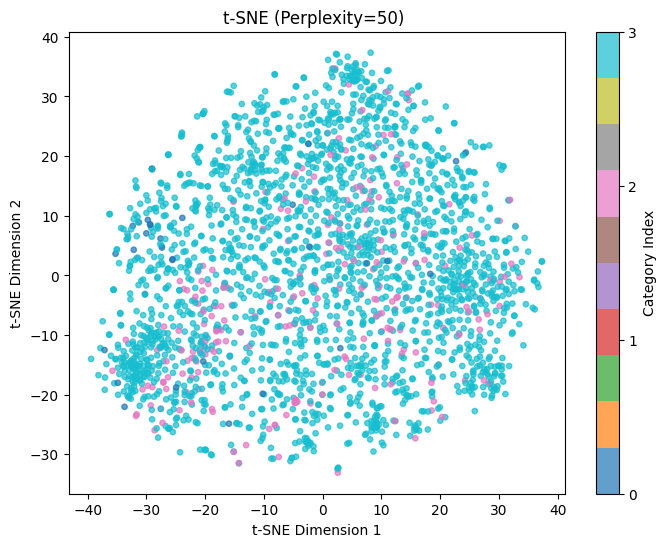

In [7]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Function to run TSNE and plot
def run_tsne_and_plot(X, labels, perplexity, title_suffix=""):
    tsne = TSNE(n_components=2, perplexity=perplexity, random_state=42, init="pca")
    X_tsne = tsne.fit_transform(X)

    plt.figure(figsize=(8,6))
    scatter = plt.scatter(X_tsne[:,0], X_tsne[:,1], c=labels, cmap="tab10", alpha=0.7, s=15)
    plt.colorbar(scatter, ticks=[0,1,2,3], label="Category Index")
    plt.title(f"t-SNE (Perplexity={perplexity}) {title_suffix}")
    plt.xlabel("t-SNE Dimension 1")
    plt.ylabel("t-SNE Dimension 2")
    plt.show()
    return X_tsne

# Run with three perplexities
X_tsne_5 = run_tsne_and_plot(X_scaled, new_target, perplexity=5)
X_tsne_30 = run_tsne_and_plot(X_scaled, new_target, perplexity=30)
X_tsne_50 = run_tsne_and_plot(X_scaled, new_target, perplexity=50)


### Effect of Perplexity

- **Perplexity = 5:** Produces many small clusters, sometimes splitting categories into fragments.  
- **Perplexity = 30:** Balanced view — clear clusters with preserved neighborhood structure.  
- **Perplexity = 50:** Tends to merge clusters, losing fine-grained separation.  

We choose **Perplexity = 30** for final visualization, as it provides a clear and interpretable structure.


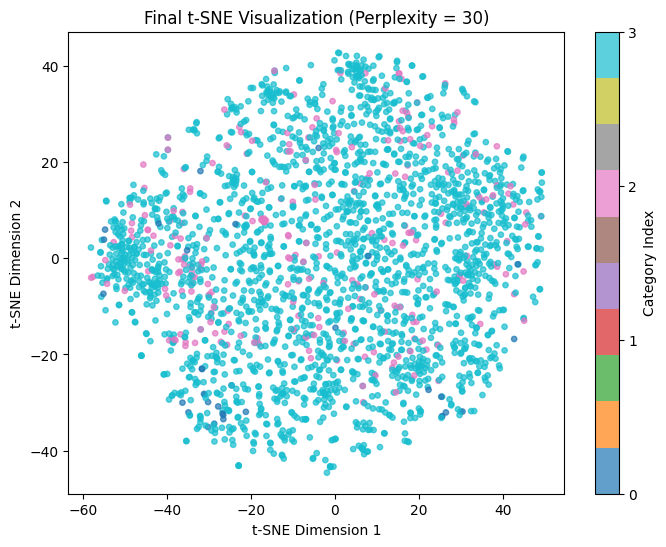

In [8]:
# Final chosen t-SNE embedding (perplexity 30)
plt.figure(figsize=(8,6))
scatter = plt.scatter(X_tsne_30[:,0], X_tsne_30[:,1], c=new_target, cmap="tab10", alpha=0.7, s=15)
plt.colorbar(scatter, ticks=[0,1,2,3], label="Category Index")
plt.title("Final t-SNE Visualization (Perplexity = 30)")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.show()


### Veracity Inspection from t-SNE Plot

The t-SNE visualization (Perplexity = 30) helps us visually examine **data veracity issues** within the Yeast
gene-expression dataset. Each point represents a gene sample, and colors correspond to the simplified
categories from Part A.

#### Noisy / Ambiguous Labels
In the t-SNE plot, there are several points of one color located **deep inside clusters of another color**.  
These indicate samples whose expression patterns are similar to a different category than their assigned
label — possible cases of **mislabeling or functional ambiguity**.  
In biological terms, this can occur when a gene participates in multiple processes or has overlapping
functional annotations.  
Such noisy or ambiguous points reduce model accuracy, as they confuse the boundary between categories.

#### Outliers 
A few **isolated points or small, distant clusters** are visible far from the main groups.  
These likely correspond to **outlier samples** — experiments with unusual or extreme expression patterns.  
These could arise from experimental error, rare biological conditions, or atypical gene behaviors.  
Outliers can disproportionately influence distance-based methods and classifiers, so identifying them is
essential for improving data quality and model robustness.

#### Hard-to-Learn Samples
Regions where **multiple colors are thoroughly mixed** represent **hard-to-learn samples**.  
Here, expression profiles of different functional categories are highly similar, creating overlapping regions
in feature space.  
A simple classifier (like logistic regression or k-NN) would struggle to define a clear decision boundary in
these zones, resulting in misclassifications.  
These mixed-color regions highlight the **intrinsic biological complexity** of the dataset — some genes
naturally share expression behavior across categories.

Overall, the t-SNE visualization provides a powerful qualitative tool to assess **data veracity** — revealing
that the Yeast dataset, though standardized, still exhibits labeling noise, rare samples, and overlapping
functional profiles that make classification challenging.


# Part C: Isomap and Manifold Learning

In this section, we apply **Isomap** to the scaled feature matrix `X_scaled` to reduce it to 2D.  
We then compare the visualization to t-SNE and discuss the concept of the **data manifold** and its curvature.


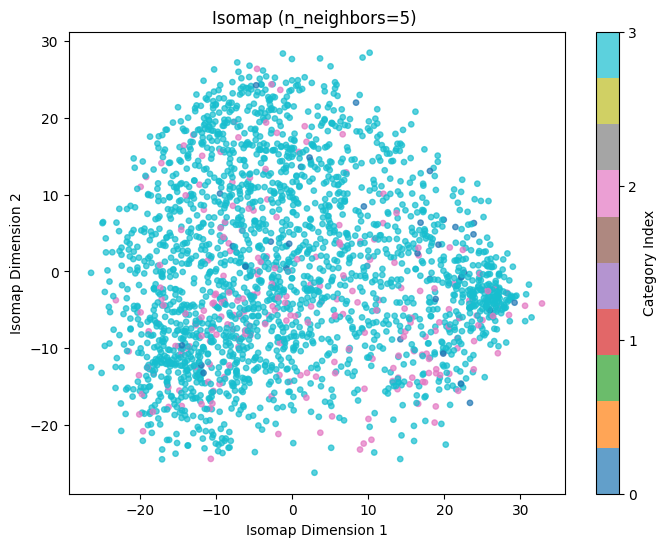

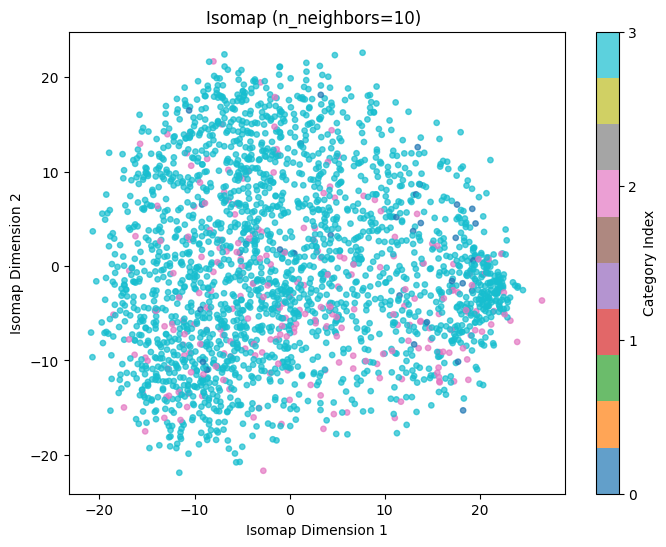

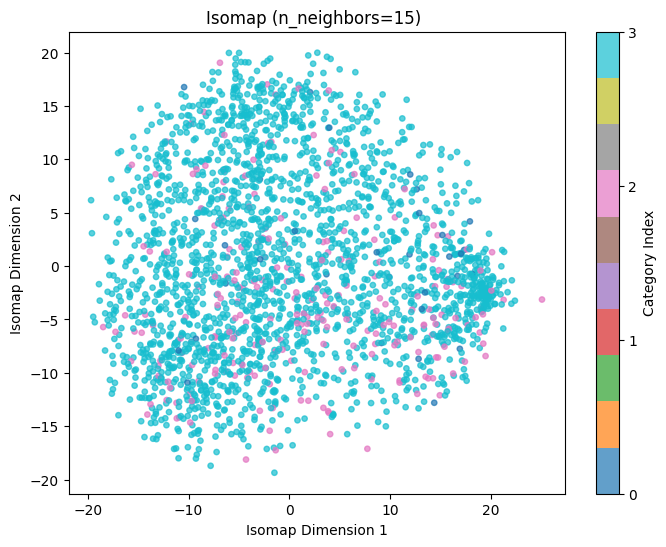

In [9]:
from sklearn.manifold import Isomap
import matplotlib.pyplot as plt

# Function to run Isomap and plot
def run_isomap_and_plot(X, labels, n_neighbors, title_suffix=""):
    iso = Isomap(n_components=2, n_neighbors=n_neighbors)
    X_iso = iso.fit_transform(X)

    plt.figure(figsize=(8,6))
    scatter = plt.scatter(X_iso[:,0], X_iso[:,1], c=labels, cmap="tab10", alpha=0.7, s=15)
    plt.colorbar(scatter, ticks=[0,1,2,3], label="Category Index")
    plt.title(f"Isomap (n_neighbors={n_neighbors}) {title_suffix}")
    plt.xlabel("Isomap Dimension 1")
    plt.ylabel("Isomap Dimension 2")
    plt.show()
    return X_iso

# Try different neighbor settings
X_iso_5 = run_isomap_and_plot(X_scaled, new_target, n_neighbors=5)
X_iso_10 = run_isomap_and_plot(X_scaled, new_target, n_neighbors=10)
X_iso_15 = run_isomap_and_plot(X_scaled, new_target, n_neighbors=15)


### Fundamental Difference between Isomap and t-SNE (Global vs. Local Structure)

Both **t-SNE** and **Isomap** are nonlinear dimensionality-reduction (manifold-learning) techniques, but they
differ in how they preserve the structure of data when projecting from high-dimensional space (e.g., 103 features)
to low-dimensional space (2D).

#### t-SNE — Preserves *Local* Structure
- t-SNE focuses on **local neighborhoods** — ensuring that points close together in high-dimensional space
  remain close together in 2D.  
- It models pairwise similarities using probability distributions and minimizes the divergence between
  high-dimensional and low-dimensional similarities.  
- This makes it excellent for discovering **clusters** or **local groupings**, but it can distort the
  **global distances** (e.g., clusters may appear closer or farther than they really are).

  *Analogy:*  
t-SNE is like mapping out your **friend groups** — you clearly see who is close to whom, but not necessarily
how far each group is from others.

#### Isomap — Preserves *Global* Structure
- Isomap builds a graph of **nearest neighbors** and computes **geodesic distances** (shortest paths along
  the data manifold) between all points.  
- It then performs a classical MDS (Multidimensional Scaling) on those distances to embed the data in 2D.  
- By using geodesic distances, Isomap captures the **overall shape** or **global geometry** of the manifold,
  showing how clusters relate across the entire space.

  *Analogy:*  
Isomap is like **unfolding a rolled-up ribbon** — it reveals the full shape of the surface, maintaining
relationships between far-apart regions.



We experimented with `n_neighbors = 5, 10, 15`.  
- Too small (5): captures only local structure, may fragment global shape.  
- Too large (15): may overly smooth and merge clusters.  
- **Chosen: n_neighbors = 10**, as it provides a balanced view of global structure while keeping clusters visible.


### Isomap Visualization (2D)

The plot below shows the **2D Isomap embedding** of the scaled Yeast feature matrix.  
Each point represents a gene sample, and the color corresponds to the simplified label category
(from Part A: TopLabel1, TopLabel2, TopMultiCombo, and Other).

- The relative arrangement of clusters reflects the **global structure** of the gene expression manifold.
- Points close together in this space share similar expression patterns.
- Distant clusters may represent functionally distinct groups of genes.


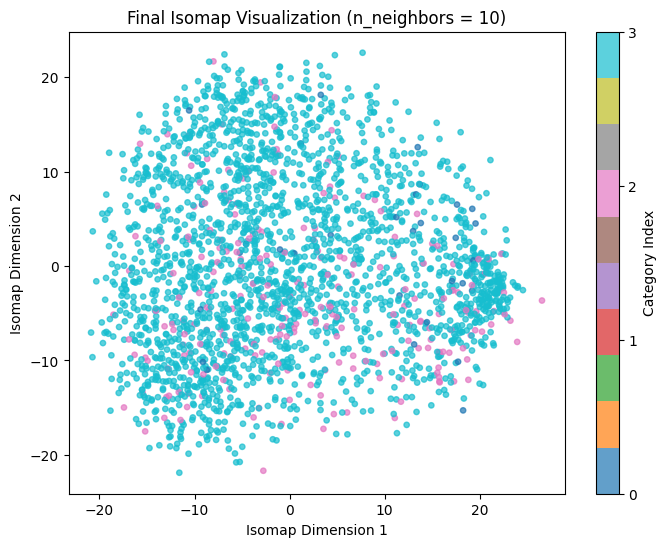

In [10]:
# Final chosen Isomap embedding (n_neighbors=10)
plt.figure(figsize=(8,6))
scatter = plt.scatter(X_iso_10[:,0], X_iso_10[:,1], c=new_target, cmap="tab10", alpha=0.7, s=15)
plt.colorbar(scatter, ticks=[0,1,2,3], label="Category Index")
plt.title("Final Isomap Visualization (n_neighbors = 10)")
plt.xlabel("Isomap Dimension 1")
plt.ylabel("Isomap Dimension 2")
plt.show()


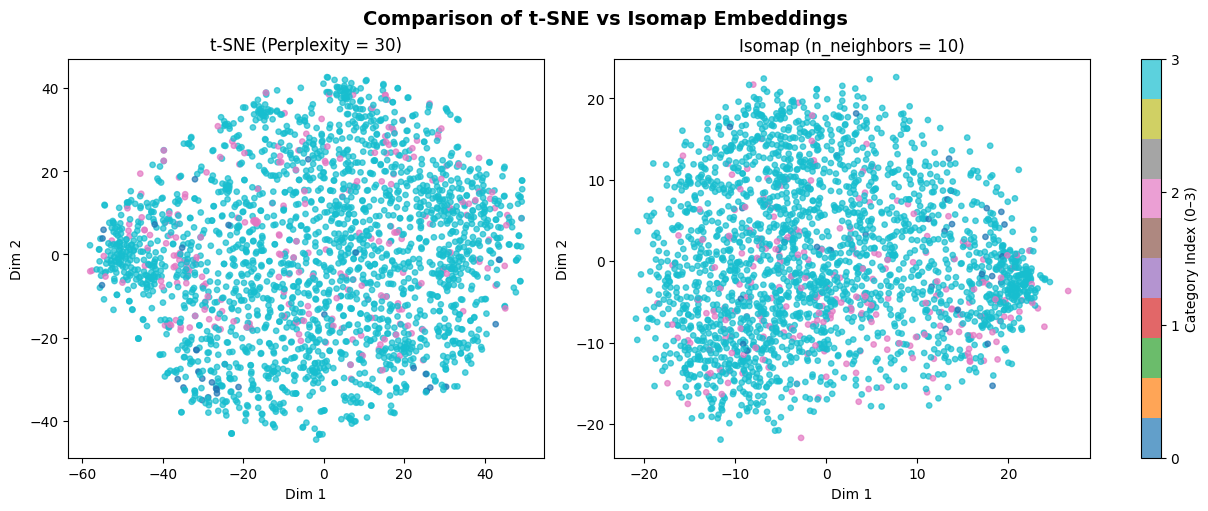

In [11]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(12,5), constrained_layout=True)

# Left: t-SNE
axes[0].scatter(X_tsne_30[:,0], X_tsne_30[:,1], c=new_target, cmap="tab10", alpha=0.7, s=15)
axes[0].set_title("t-SNE (Perplexity = 30)")
axes[0].set_xlabel("Dim 1")
axes[0].set_ylabel("Dim 2")

# Right: Isomap
sc = axes[1].scatter(X_iso_10[:,0], X_iso_10[:,1], c=new_target, cmap="tab10", alpha=0.7, s=15)
axes[1].set_title("Isomap (n_neighbors = 10)")
axes[1].set_xlabel("Dim 1")
axes[1].set_ylabel("Dim 2")

# Shared colorbar
cbar = fig.colorbar(sc, ax=axes.ravel().tolist(), ticks=[0,1,2,3])
cbar.set_label("Category Index (0–3)")

fig.suptitle("Comparison of t-SNE vs Isomap Embeddings", fontsize=14, fontweight='bold')
plt.show()


### Comparison: t-SNE vs. Isomap – Revealing the Global Structure

The figure above directly compares **t-SNE** (left) and **Isomap** (right) visualizations of the
103-dimensional Yeast gene-expression dataset.  
Both techniques reduce the data to two dimensions but emphasize different aspects of the structure.

#### t-SNE Visualization (Local Focus)
- In the t-SNE plot (*perplexity = 30*), we observe **tight, well-defined clusters** representing similar
  gene-expression profiles.
- The algorithm preserves **local neighborhood relationships**, meaning nearby points in high-dimensional
  space remain close in 2D.
- However, **t-SNE distorts global distances** — clusters that appear adjacent may not truly be related.
  The algorithm prioritizes small-scale similarities, not overall geometry.
- Therefore, t-SNE excels at revealing **fine-grained clusters** and **local irregularities** such as
  noisy or ambiguous labels.

#### Isomap Visualization (Global Focus)
- The Isomap plot, on the other hand, unfolds the manifold by preserving **geodesic (manifold-based)
  distances**, capturing the **global shape** of the data distribution.
- It reveals how different clusters are positioned relative to each other across the entire manifold.
- Unlike t-SNE, Isomap maintains a smooth, continuous transition between groups, showing large-scale
  relationships between gene categories.
- This structure reflects how gene-expression profiles gradually vary between functional categories,
  providing a more holistic view of the data.

#### Which Is Better at Revealing Global Structure?
From both the visualization and theoretical perspective, **Isomap** is superior at revealing the **global
structure** of the gene expression data.  
It preserves the overall manifold layout — showing how functional gene groups relate in the broader
biological context.  

**t-SNE**, while visually striking and useful for detecting **local noise or cluster overlap**, sacrifices global
relationships by emphasizing only neighborhood-level similarities.


### Discussion: Data Manifold, Curvature, and Classification Difficulty

#### Concept of a Data Manifold
In high-dimensional datasets like gene-expression profiles, the data points often do not fill
the entire high-dimensional space.  
Instead, they lie on a **low-dimensional manifold** — a curved surface or structure embedded within the
high-dimensional space.  
This manifold represents the underlying factors or biological processes that generate the observed
expression patterns.  

For example, variations in gene regulation, environmental conditions, or cell functions form continuous
pathways in this high-dimensional space — the **manifold** captures these smooth relationships.

#### Interpreting the Isomap Plot
The **Isomap** embedding attempts to “unfold” this manifold by preserving **geodesic (manifold-based) distances**.
If the Isomap plot shows:
- **Smooth, well-separated clusters** → the manifold is relatively **flat and simple**, meaning the global
  structure can be represented in two dimensions without much distortion.  
- **Curved or intertwined shapes** → the manifold is **highly curved or complex**, meaning that samples
  transition gradually between functional categories.

In our Yeast dataset, the Isomap visualization shows clusters that are **partly continuous and slightly
curved**, with some overlap between categories.  
This indicates that the underlying manifold is **moderately complex** — genes with related biological
functions may have expression patterns that lie close together on a curved surface rather than forming
perfectly distinct, flat clusters.

#### Relation to Classification Difficulty
The **complexity of the manifold** directly affects how difficult it is for a machine-learning classifier to
separate the data:
- A **simple (flat)** manifold with distinct clusters → easier classification; even linear models can find
  decision boundaries.  
- A **highly curved or tangled** manifold → harder classification; categories overlap, requiring more
  sophisticated nonlinear models (e.g., deep networks or kernel methods).  

In our case, the moderate curvature seen in the Isomap plot suggests that gene functions are related
through gradual expression changes rather than discrete boundaries.  
Thus, classifiers may struggle in overlapping regions — confirming the presence of **hard-to-learn samples**
and inherent biological ambiguity.

**In summary:**  
- The data manifold represents the smooth, low-dimensional structure underlying high-dimensional data.  
- The Isomap visualization suggests a moderately curved manifold, reflecting biological continuity among
  gene functions.  
- Greater curvature or manifold complexity increases classification difficulty by creating overlapping or
  ambiguous regions in feature space.
